In [1]:
import datetime
import math
import requests
import pandas as pd

In [2]:
IEX_CLOUD_API_TOKEN = 'Tpk_059b97af715d417d9f49f50b51b1c448'
BASE_URL = 'https://sandbox.iexapis.com/stable'

In [6]:
symbol='5 HK'

api_url = f'{BASE_URL}/time-series/fundamentals/{symbol}/annual?last=10&token={IEX_CLOUD_API_TOKEN}'
raw_data = requests.get(api_url).json()
raw_data
# raw_data.sort(key=lambda d : d['updated'])

[]

In [4]:
# balance sheet - 3000
# income statement - 1000

def calculate_roic(annual_report):
    tax_rate = annual_report['incomeTaxRate'] # incomeTax / pretaxIncome

    # income statement
    operating_income = annual_report['incomeFromOperations'] # operatingIncome

    # balance sheet
    short_term_debt = annual_report['debtShortTerm'] # ?
    long_term_debt = annual_report['liabilitiesNonCurrentDebt'] # longTermDebt
    equity = annual_report['equityShareholder'] # shareholderEquity

    nopat = operating_income * (1 - tax_rate)
    invested_capital = short_term_debt + long_term_debt + equity

    return nopat / invested_capital

In [5]:
def get_stats(annual_report):
    updated = int(annual_report['updated']) / 1000.0
    date = datetime.datetime.fromtimestamp(updated).strftime('%Y-%m-%d')
    
    revenue = annual_report['revenue']
    eps = annual_report['incomeNetPerWabsoSplitAdjusted'] # incomeNetPerWabsoSplitAdjustedYoyDeltaPercent
    equity = annual_report['equityShareholder']
    cash = annual_report['assetsCurrentCash']
    roic = calculate_roic(annual_report)
    return {
        'date': date,
        'revenue': revenue,
        'eps': eps,
        'equity': equity,
        'cash': cash,
        'roic': roic
    }

In [6]:
financials = list(map(get_stats, raw_data))

financials # sanity check

[{'date': '2021-10-26',
  'revenue': 225858912037,
  'eps': 2.12805854123402,
  'equity': 129753044111,
  'cash': 69565907952,
  'roic': 0.21161477638641363},
 {'date': '2021-10-26',
  'revenue': 110052475942,
  'eps': 1.0465245200296,
  'equity': 77938510995,
  'cash': 26563224930,
  'roic': 0.3310849756120556},
 {'date': '2021-11-20',
  'revenue': 271091730271,
  'eps': 3.12951540066376,
  'equity': 109939696275,
  'cash': 69450042929,
  'roic': 0.25323159227151126},
 {'date': '2021-12-18',
  'revenue': 237015321021,
  'eps': 2.39833718536367,
  'equity': 119370925713,
  'cash': 42322108742,
  'roic': 0.28838398611949806},
 {'date': '2022-01-26',
  'revenue': 189913826697,
  'eps': 1.63645963168854,
  'equity': 114286411702,
  'cash': 26043827412,
  'roic': 0.2592797995567332},
 {'date': '2022-09-23',
  'revenue': 284035912975,
  'eps': 3.42016123111136,
  'equity': 67160600263,
  'cash': 93108772998,
  'roic': 0.31460427482987785},
 {'date': '2022-10-10',
  'revenue': 177636653704,


In [7]:
# Big Five calculations
columns = ['financial'] + list(map(lambda x: x['date'], financials))
big_five_df = pd.DataFrame(columns=columns)

for financial in ['revenue', 'eps', 'equity', 'cash', 'roic']:
    row = [financial] + list(map(lambda x: x[financial], financials))
    big_five_df = big_five_df.append(
            pd.Series(row, index = columns),
            ignore_index = True)

big_five_df = big_five_df.set_index('financial')

In [8]:
# Growth rates calculation

n_year_growth_rates = [9, 5, 3, 1] # n-year growth rates to calculate

columns = ['financial'] + [f'{year}-year growth rate' for year in n_year_growth_rates]

growth_rate_df = pd.DataFrame(columns=columns)

def calculate_growth_rate(start, end, years):
    return (end/start)**(1/years) - 1

for financial in ['revenue', 'eps', 'equity', 'cash', 'roic']:
    row = [financial]

    for years in n_year_growth_rates:
        start = financials[-(years + 1)][financial]
        end = financials[-1][financial]
        growth_rate = calculate_growth_rate(start, end, years)       
        row.append(growth_rate)

    growth_rate_df = growth_rate_df.append(
        pd.Series(row, index = columns),
        ignore_index = True)

growth_rate_df = growth_rate_df.set_index('financial')

# Big Five checks
In descending order of importance:
1. ROIC
2. Equity
3. EPS
4. Sales
5. Cash

In [17]:
big_five_df

,2021-10-26,2021-10-26,2021-11-20,2021-12-18,2022-01-26,2022-09-23,2022-10-10,2023-02-20,2023-03-10,2023-06-21
financial,,,,,,,,,,
revenue,225858912037,110052475942,271091730271,237015321021,189913826697,284035912975,177636653704,162352207763,268296084361,232878600026
eps,2.12806,1.04652,3.12952,2.39834,1.63646,3.42016,1.46663,1.64767,3.12983,2.40824
equity,129753044111,77938510995,109939696275,119370925713,114286411702,67160600263,127376031183,121326569144,92544380983,134449548212
cash,69565907952,26563224930,69450042929,42322108742,26043827412,93108772998,42323814395,30154548005,102469189443,75808964794
roic,0.211615,0.331085,0.253232,0.288384,0.25928,0.314604,0.248094,0.351196,0.268876,0.183533


Text(0.5, 1.0, 'Big Five numbers')

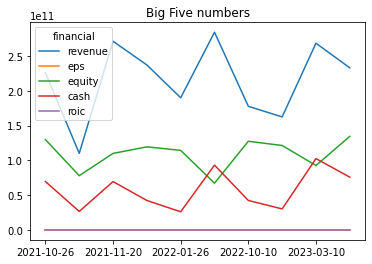

In [15]:
big_five_df.T.plot().set_title('Big Five numbers')

In [11]:
growth_rate_df

,9-year growth rate,5-year growth rate,3-year growth rate,1-year growth rate
financial,,,,
revenue,0.003407,0.041633,0.094458,-0.132009
eps,0.013838,0.080336,0.179759,-0.230552
equity,0.003958,0.033030,0.018178,0.452812
cash,0.009595,0.238235,0.214447,-0.260178
roic,-0.015694,-0.066769,-0.095588,-0.317404


Text(0.5, 1.0, 'Big Five numbers growth rates')

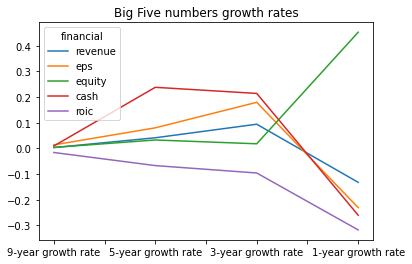

In [16]:
growth_rate_df.T.plot().set_title('Big Five numbers growth rates')

In [13]:
def print_big_five_report(min_acceptable_growth_rate):
    print(f'Is it >={min_acceptable_growth_rate}?')
    for financial, row in growth_rate_df.iterrows():
        is_good = True
        for number in row:
            if(number < 0.1):
                is_good = False
        print(f'{financial}: {"yes" if is_good else "no"}')

print_big_five_report(0.1)

Is it >=0.1?
revenue: no
eps: no
equity: no
cash: no
roic: no


# Calculate sticker price

In [19]:
# current EPS
# Estimated EPS growth rate
# Estimated future PE
# Minimum rate of return (15%)
# MOS (50%)

current_financials = raw_data[-1]

eps = 

{'accountsPayable': 50529209966,
 'accountsPayableTurnover': 4.83714420039668,
 'accountsReceivable': 35739216317,
 'accountsReceivableTurnover': 6.48216314773142,
 'asOfDate': '2021-01-19',
 'assetsCurrentCash': 75808964794,
 'assetsCurrentCashRestricted': 0,
 'assetsCurrentDeferredCompensation': 0,
 'assetsCurrentDeferredTax': 0,
 'assetsCurrentDiscontinuedOperations': 0,
 'assetsCurrentInvestments': 0,
 'assetsCurrentLeasesOperating': 0,
 'assetsCurrentLoansNet': 0,
 'assetsCurrentOther': 14197258163,
 'assetsCurrentSeparateAccounts': 0,
 'assetsCurrentUnadjusted': 130337164820,
 'assetsFixed': 256713866312,
 'assetsFixedDeferredCompensation': 0,
 'assetsFixedDeferredTax': 0,
 'assetsFixedDiscontinuedOperations': 0,
 'assetsFixedLeasesOperating': 0,
 'assetsFixedOperatingDiscontinuedOperations': 0,
 'assetsFixedOperatingSubsidiaryUnconsolidated': 0,
 'assetsFixedOreo': 0,
 'assetsFixedOther': 10424918903,
 'assetsFixedUnconsolidated': 0,
 'assetsUnadjusted': 393169595168,
 'capex': 